# 학습 방법 - Scene

3개의 Scene에 대해서 각각 따로 학습

user별로 학습을 하지 않는 이유는 상관관계로 보았을 때 user끼리는 달라도 scene별로는 유사점이 꽤 보였기 때문.

In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
EXPERIMENT_NAME = 'Scene1-MLP'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene1_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene1_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [3]:
WINDOW_SIZE = 60

In [4]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [5]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=1, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=1, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [6]:
len(ds_train), len(ds_test)

(55167, 57167)

In [7]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([60, 6]), torch.Size([3]))

In [8]:
x, y = ds_train[0]

In [9]:
x.shape

torch.Size([60, 6])

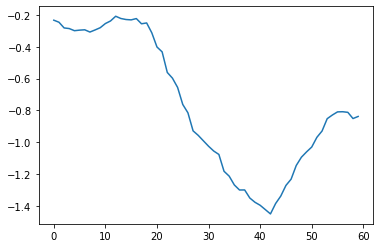

In [10]:
plt.plot(x[:, 2])

# 모델 생성

StackedLSTM Bidirectional

In [11]:
model = utils.BaselineLSTM(input_size=6,
                           hidden_size=24,
                           num_layers=8,
                           dropout=0.1,
                           bidirectional=True).cuda()

In [12]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [13]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [14]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [15]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [16]:
trainer.fit(ds_train, ds_test, num_epochs=100, batch_size=256, shuffle=True, pin_memory=True)

[0002/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   8.039675
 - Pitch        :   9.155427
 - Roll         :   2.973998
 - RMS          :   7.241153
 - 99% Tile     :  40.438675
Save output signals into checkpoint/Scene1-MLP/sample/0001.npy


[0003/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.848062
 - Pitch        :   5.855194
 - Roll         :   2.889786
 - RMS          :   5.060763
 - 99% Tile     :  33.568176
Save output signals into checkpoint/Scene1-MLP/sample/0002.npy


[0004/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.191126
 - Pitch        :   4.038946
 - Roll         :   2.827189
 - RMS          :   3.735935
 - 99% Tile     :  28.971157
Save output signals into checkpoint/Scene1-MLP/sample/0003.npy


[0005/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.324428
 - Pitch        :   3.110113
 - Roll         :   2.493483
 - RMS          :   2.996781
 - 99% Tile     :  25.453192
Save output signals into checkpoint/Scene1-MLP/sample/0004.npy


[0006/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.340604
 - Pitch        :   2.512735
 - Roll         :   2.008255
 - RMS          :   2.296762
 - 99% Tile     :  22.287945
Save output signals into checkpoint/Scene1-MLP/sample/0005.npy


[0007/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.938162
 - Pitch        :   2.022117
 - Roll         :   1.584195
 - RMS          :   1.857875
 - 99% Tile     :  19.107775
Save output signals into checkpoint/Scene1-MLP/sample/0006.npy


[0008/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.558798
 - Pitch        :   1.746826
 - Roll         :   1.326401
 - RMS          :   1.553554
 - 99% Tile     :  16.114151
Save output signals into checkpoint/Scene1-MLP/sample/0007.npy


[0009/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.442634
 - Pitch        :   1.485901
 - Roll         :   1.135768
 - RMS          :   1.363704
 - 99% Tile     :  14.249859
Save output signals into checkpoint/Scene1-MLP/sample/0008.npy


[0010/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.398673
 - Pitch        :   1.417290
 - Roll         :   1.057313
 - RMS          :   1.301654
 - 99% Tile     :  12.858797
Save output signals into checkpoint/Scene1-MLP/sample/0009.npy


[0011/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.260453
 - Pitch        :   1.258872
 - Roll         :   1.005906
 - RMS          :   1.181150
 - 99% Tile     :  12.439672
Save output signals into checkpoint/Scene1-MLP/sample/0010.npy


[0012/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.210923
 - Pitch        :   1.239240
 - Roll         :   0.943054
 - RMS          :   1.138918
 - 99% Tile     :  12.551012
Save output signals into checkpoint/Scene1-MLP/sample/0011.npy


[0013/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.112722
 - Pitch        :   1.135839
 - Roll         :   0.936938
 - RMS          :   1.065541
 - 99% Tile     :  11.293539
Save output signals into checkpoint/Scene1-MLP/sample/0012.npy


[0014/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.206062
 - Pitch        :   1.106897
 - Roll         :   0.868782
 - RMS          :   1.069983
 - 99% Tile     :  11.709843
Save output signals into checkpoint/Scene1-MLP/sample/0013.npy


[0015/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.273917
 - Pitch        :   1.053202
 - Roll         :   0.839402
 - RMS          :   1.070311
 - 99% Tile     :  11.376478
Save output signals into checkpoint/Scene1-MLP/sample/0014.npy


[0016/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.170126
 - Pitch        :   1.120201
 - Roll         :   0.804014
 - RMS          :   1.044108
 - 99% Tile     :  11.431946
Save output signals into checkpoint/Scene1-MLP/sample/0015.npy


[0017/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.103976
 - Pitch        :   0.915864
 - Roll         :   0.804724
 - RMS          :   0.949588
 - 99% Tile     :  10.339651
Save output signals into checkpoint/Scene1-MLP/sample/0016.npy


[0018/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.069694
 - Pitch        :   0.951467
 - Roll         :   0.771804
 - RMS          :   0.939010
 - 99% Tile     :   9.387890
Save output signals into checkpoint/Scene1-MLP/sample/0017.npy


[0019/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.061562
 - Pitch        :   0.948662
 - Roll         :   0.804918
 - RMS          :   0.944240
 - 99% Tile     :   9.738796
Save output signals into checkpoint/Scene1-MLP/sample/0018.npy


[0020/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.062456
 - Pitch        :   0.932523
 - Roll         :   0.804759
 - RMS          :   0.939157
 - 99% Tile     :  10.077419
Save output signals into checkpoint/Scene1-MLP/sample/0019.npy


[0021/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.111697
 - Pitch        :   1.076539
 - Roll         :   0.788484
 - RMS          :   1.002748
 - 99% Tile     :   9.848244
Save output signals into checkpoint/Scene1-MLP/sample/0020.npy


[0022/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.086195
 - Pitch        :   0.932821
 - Roll         :   0.750895
 - RMS          :   0.933420
 - 99% Tile     :   9.873905
Save output signals into checkpoint/Scene1-MLP/sample/0021.npy


[0023/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.209720
 - Pitch        :   0.917496
 - Roll         :   0.737728
 - RMS          :   0.974588
 - 99% Tile     :  11.802305
Save output signals into checkpoint/Scene1-MLP/sample/0022.npy


[0024/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   1.162557
 - Pitch        :   0.958642
 - Roll         :   0.732859
 - RMS          :   0.967405
 - 99% Tile     :  12.522636
Save output signals into checkpoint/Scene1-MLP/sample/0023.npy


[0025/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   1.082747
 - Pitch        :   0.863649
 - Roll         :   0.758157
 - RMS          :   0.911598
 - 99% Tile     :  10.657085
Save output signals into checkpoint/Scene1-MLP/sample/0024.npy


[0026/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   1.169279
 - Pitch        :   0.901240
 - Roll         :   0.730646
 - RMS          :   0.951015
 - 99% Tile     :  12.499954
Save output signals into checkpoint/Scene1-MLP/sample/0025.npy


[0027/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   1.126463
 - Pitch        :   0.878890
 - Roll         :   0.742575
 - RMS          :   0.929656
 - 99% Tile     :  10.461273
Save output signals into checkpoint/Scene1-MLP/sample/0026.npy


[0027/0100] Validation: 100%|████████████████████| 224/224 [00:05<00:00, 44.64it/s, val_loss 5.5883]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 5 epochs
val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :   1.160097
 - Pitch        :   0.913740
 - Roll         :   0.748255
 - RMS          :   0.955795
 - 99% Tile     :  11.289589
Save output signals into checkpoint/Scene1-MLP/sample/0027.npy
